## Playground

## Image checks

### Corrupt image for testing purposes

In [ ]:
image_to_corrupt = "C:/tasks/gyg/flowers102/flowers-102/jpg/image_00001.jpg"

with open(image_to_corrupt, "rb") as f:
    data = f.read()


with open(image_to_corrupt, 'wb') as f:
    f.write(data[:100])


### Scan and quarentine images

In [ ]:
from utils.preprocessing import scan_folder_parallel

scan_folder_parallel("C:/tasks/gyg/flowers102/flowers-102/jpg", "C:/tasks/gyg/flowers102/flowers-102/quarantine", max_workers=8)

Should you get any BAD images, the dataset must be updated!

## Load dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt

transforms = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")), 
    T.Resize((128, 128)), 
    T.ToTensor()
    ])

train_dataset = torchvision.datasets.Flowers102('flowers102', split='train', download=True, transform=transforms) 
val_dataset   = torchvision.datasets.Flowers102('flowers102', split='val',   download=True, transform=transforms) 
test_dataset  = torchvision.datasets.Flowers102('flowers102', split='test',  download=True, transform=transforms) 
print(f'Samples in train_dataset: {len(train_dataset)}')
print(f'Samples in val_dataset: {len(val_dataset)}')
print(f'Samples in test_dataset: {len(test_dataset)}')

dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

print(f'Number of labels: {len(train_dataset.classes)}. E.g.: {train_dataset.classes[:5]}')
print(f'Number of samples: {len(dataset)}')

data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

for imgs, labels in data_loader:
    img = imgs[:1, :3, :, :]
    plt.imshow(img.permute(0, 2, 3, 1).squeeze())
    print("Batch shape:", imgs.shape)
    print("Labels shape:", labels.shape)
    break

# Extract embeddings

In [ ]:
import torchvision.models as models

resnet152_torch = models.resnet152(pretrained=True)

layers = list(resnet152_torch.children())[:-1]

resnet152_body = torch.nn.Sequential(*layers)

# resnet152_body.eval()

## Visualize feature vector and extract D

In [ ]:
from torch import Tensor

with torch.no_grad():
    for imgs, labels in data_loader:
        features:Tensor = resnet152_body(imgs[:2])

        img = imgs[0]
        feature = features[0]

        # Extract D
        D = feature.shape[0]

        print("Img shape:", img.shape)
        print("Feature shape:", feature.shape)

        # Visualize image and features
        fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax1.imshow(img.permute(1, 2, 0).squeeze())
        ax1.set_title("Image")
        ax2.plot(feature.squeeze())
        ax2.set_title("Features")
        break

### Store as memmap

In [ ]:
import numpy as np
from tqdm import tqdm

N = len(data_loader.dataset)

memmap_feat_path = '../features.dat'
features_mm = np.memmap(memmap_feat_path, dtype='float32', mode='r+', shape=(N,D))

memmap_labels_path = '../labels.dat'
labels_mm = np.memmap(memmap_labels_path, dtype='int64', mode='r+', shape=(N,))

idx = 0
with torch.no_grad():
    for imgs, labs in tqdm(data_loader, total=len(data_loader)):
        b = imgs.size(0)
        imgs = imgs.to('cpu')
        feats = resnet152_body(imgs).view(b, -1)
        feats = feats.detach().cpu().numpy().astype(np.float32)
        features_mm[idx:idx+b, :] = feats
        labels_mm[idx:idx+b] = labs.numpy()
        idx += b

# flush to disk
features_mm.flush()
labels_mm.flush()

## Store as HDF5

In [ ]:
import h5py
import numpy as np
from tqdm import tqdm

N = len(data_loader.dataset)
# determine D as before
with h5py.File('flowers.h5', 'w') as hf:
    feat_ds = hf.create_dataset('features', shape=(N, D), dtype='float32')
    label_ds = hf.create_dataset('labels', shape=(N,), dtype='int64')
    # optional: save paths as variable-length UTF-8 str dtype
    str_dt = h5py.string_dtype(encoding='utf-8')
    path_ds = hf.create_dataset('paths', shape=(N,), dtype=str_dt)

    idx = 0
    with torch.no_grad():
        for imgs, labs in tqdm(data_loader, total=len(data_loader)):
            b = imgs.size(0)
            imgs = imgs.to(device)
            feats = resnet152_body(imgs).view(b, -1)
            feats = feats.detach().cpu().numpy().astype(np.float32)
            feat_ds[idx:idx+b] = feats
            label_ds[idx:idx+b] = labs.numpy()
            # path_ds[idx:idx+b] = batch_paths
            idx += b


# Cluster images

## Load features

In [ ]:
import numpy as np

memmap_feat_path = '../features.dat'
memmap_labels_path = '../labels.dat'

feats = np.memmap(memmap_feat_path, dtype='float32', mode='r', shape=(N, D))
labels = np.memmap(memmap_labels_path, dtype='int64', mode='r', shape=(N,))
print(f'Feats [{feats.shape}]: {feats[50:55]}')

labels_text = [train_dataset.classes[label] for label in labels]
print(f'Labels [{labels.shape[0]}]: {labels_text[50:55]}')

## Reduce dimensionality: PCA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

np.random.seed(7)

feats_array = np.asarray(feats) 

pca_dim = 128
num_samples = 1000

samples_idx = np.random.choice(feats_array.shape[0], size = min(num_samples, feats_array.shape[0]), replace=False)
samples = feats_array[samples_idx]

pca = PCA(n_components=pca_dim, whiten=False)
pca.fit(samples)

fig = plt.figure(figsize=plt.figaspect(0.5))

feats_pca = pca.transform(feats_array)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("PCA feats [:2] non normalized")
ax1.scatter(feats_pca[:1000,0], feats_pca[:1000,1], feats_pca[:1000,2])

feats_pca_normalized = normalize(feats_pca, axis=1, norm='l2').astype(np.float32)
print(f'PCA feats normalized [{feats_pca_normalized.shape}]: {feats_pca_normalized[50:55]}')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title("PCA feats [:2] normalized")
ax2.scatter(feats_pca_normalized[:1000,0], feats_pca_normalized[:1000,1], feats_pca_normalized[:1000,2])
plt.show()

## Cluster

### K-Means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=102, random_state=0, n_init="auto").fit(feats_pca_normalized)

# Create indices
kmeans_inv_index = {}
for i, lab in enumerate(kmeans.labels_):
    k = int(lab)
    try:
        kmeans_inv_index[k].append(i)
    except KeyError:
        kmeans_inv_index[k] = [i]

gt_inv_index = {}
for i, lab in enumerate(labels):
    k = int(lab)
    try:
        gt_inv_index[k].append(i)
    except KeyError:
        gt_inv_index[k] = [i]


In [ ]:
example_index = 1550

# Visualize input image
img, label = data_loader.dataset[example_index]
fig0 = plt.figure()
ax0 = fig0.add_subplot()
ax0.imshow(img.permute(1, 2, 0).squeeze())
ax0.set_title(f"Input image: {labels_text[example_index]}")

# Compute ground truth indices
# kmeans_label = labels.tolist()[example_index]
# similar_images_indices = gt_inv_index[kmeans_label]
# print(similar_images_indices)

# Compute kmeans evaluation indices
kmeans_label = kmeans.labels_[example_index]
similar_images_indices = kmeans_inv_index[kmeans_label]
print(similar_images_indices)

num_rows = len(similar_images_indices)//5 + 1
fig = plt.figure(figsize=[10, 2.5*num_rows])

for i, idx in enumerate(similar_images_indices):
    img, label = data_loader.dataset[idx]
    kmeans_label = kmeans.labels_[idx]

    row = i//5
    ax = fig.add_subplot(num_rows, 5, i+1)
    ax.imshow(img.permute(1, 2, 0).squeeze())
    ax.set_title(f"{labels_text[idx]}")

# Train-fit  _flowers102_  dataset

In [1]:
from utils.train import TrainFlowerImageSearch
from utils.plot import plot_image_from_index, plot_images_from_index

tfis = TrainFlowerImageSearch(dataset='../flowers102', model_location='../models/kmeans_search/', batch_size=64)

tfis.train_fit()

Starting training and fitting process...
Loading dataset...
Samples in dataset: 8189
Loading feature extractor...


c:\Users\jedev\AppData\Local\pypoetry\Cache\virtualenvs\gyg-uPVOmiYi-py3.13\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jedev\AppData\Local\pypoetry\Cache\virtualenvs\gyg-uPVOmiYi-py3.13\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Indexing dataset...


100%|██████████| 128/128 [03:26<00:00,  1.61s/it]


Fitting PCA with 1000 samples and 128 dimensions...
PCA feats normalized [(8189, 128)]: [[-1.32171825e-01 -2.08880231e-01 -5.10043085e-01 -6.07166141e-02
   1.08092584e-01 -1.00846989e-02  8.25399980e-02  1.62636921e-01
   2.45384276e-01 -1.61915887e-02  8.39105342e-03 -2.67234504e-01
   2.14515775e-01 -2.61097521e-01  1.06995761e-01 -5.27116470e-02
   4.59752865e-02  5.30751161e-02  1.36698112e-02  2.17360362e-01
  -1.20745726e-01 -3.74025851e-02  1.44067835e-02  3.27825285e-02
   5.66821545e-02  9.47219580e-02  7.52838701e-02 -3.38844210e-02
  -7.72064328e-02  8.90804455e-02 -2.51536705e-02  5.90535142e-02
   1.58230029e-02  1.15713133e-02  6.56750128e-02  6.49791360e-02
  -1.42178282e-01 -7.98444599e-02  2.41365898e-02 -5.99822449e-03
   7.61904195e-02 -7.48797059e-02  4.31249253e-02  2.06042863e-02
  -4.83435541e-02 -4.44799382e-03 -7.26534575e-02  1.12639265e-02
  -3.28419395e-02 -1.47671103e-02  9.67916697e-02 -4.63597402e-02
   2.62250733e-02 -1.01293940e-02  5.70431724e-02  5.5

## Plot results

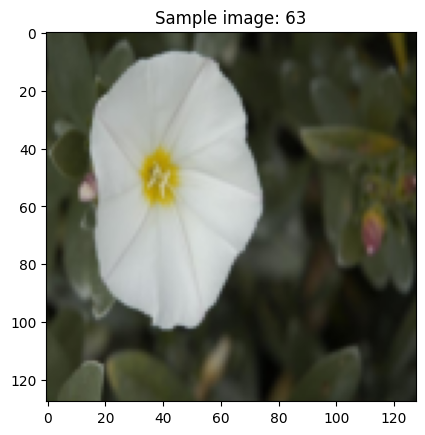

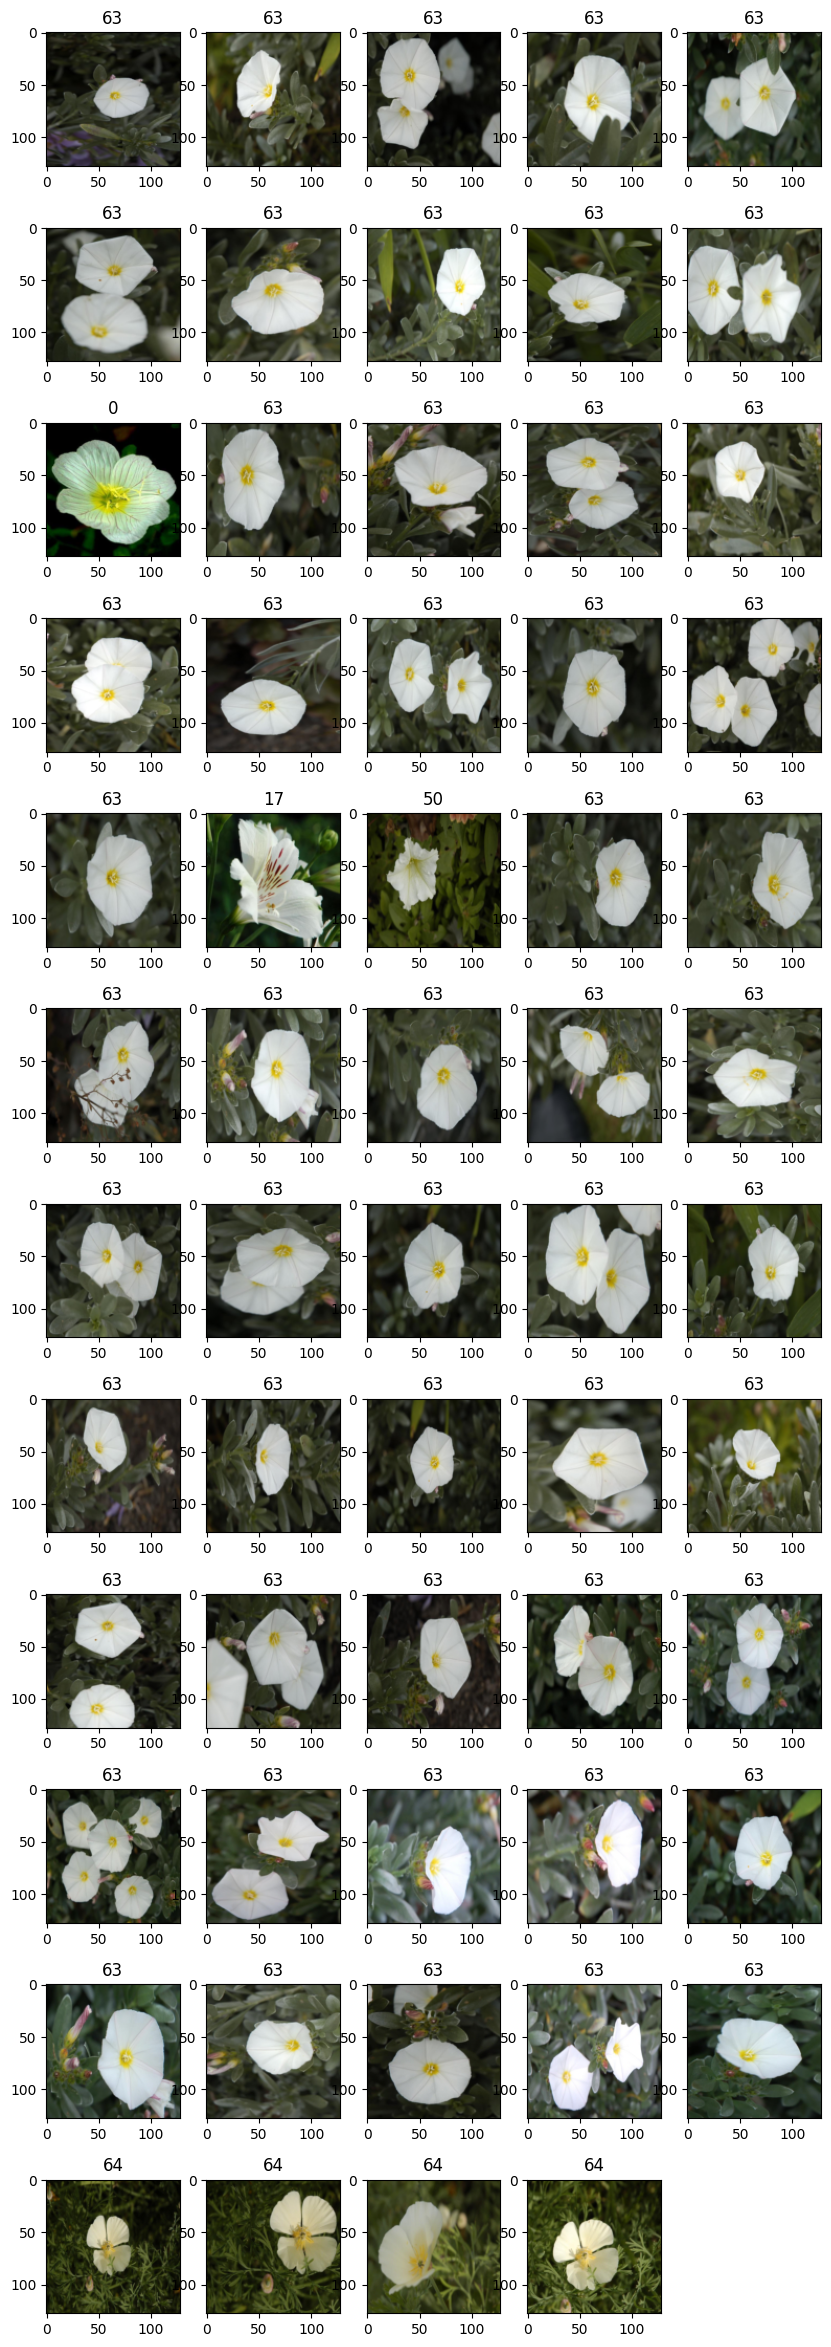

In [8]:
example_index = 1650
similar_images_indices = tfis.get_similar_cluster(example_index)

# Visualize example image
plot_image_from_index(tfis.data_loader, example_index)

# Compute kmeans evaluation indices
plot_images_from_index(tfis.data_loader, similar_images_indices)

# Search similar flower

In [9]:
from utils.plot import plot_image_from_path, plot_images_from_index
from utils.train import TrainFlowerImageSearch

search_tfis = TrainFlowerImageSearch(dataset='../flowers102', model_location='../models/kmeans_search/', batch_size=32)

dahlia.jpg
Loading model components from ../models/kmeans_search/fit_params.pkl...
Model components loaded successfully.
Loading dataset...
Samples in dataset: 8189
Loading feature extractor...


c:\Users\jedev\AppData\Local\pypoetry\Cache\virtualenvs\gyg-uPVOmiYi-py3.13\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jedev\AppData\Local\pypoetry\Cache\virtualenvs\gyg-uPVOmiYi-py3.13\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Images found (first 10 images): [88, 242, 243, 244, 246, 248, 249, 784, 1101, 1260]
jasmine.jpg
Images found (first 10 images): [103, 772, 904, 1081, 1083, 1370, 1549, 1634, 1791, 1792]
lotus.jpg
Images found (first 10 images): [124, 234, 293, 382, 386, 775, 776, 802, 1207, 1209]
orange_daisy.jpg
Images found (first 10 images): [116, 330, 333, 402, 406, 482, 490, 530, 531, 532]
orchid.jpg
Images found (first 10 images): [770, 771, 773, 774, 777, 778, 1045, 1568, 1753, 1790]
poinsetta.jpg
Images found (first 10 images): [34, 188, 430, 432, 433, 435, 438, 969, 1373, 1450]
rose.jpg
Images found (first 10 images): [447, 511, 763, 814, 921, 922, 923, 926, 929, 985]


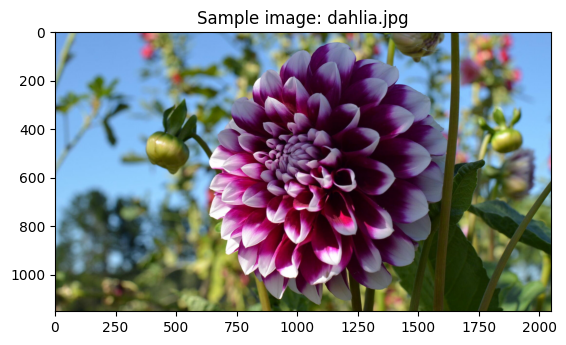

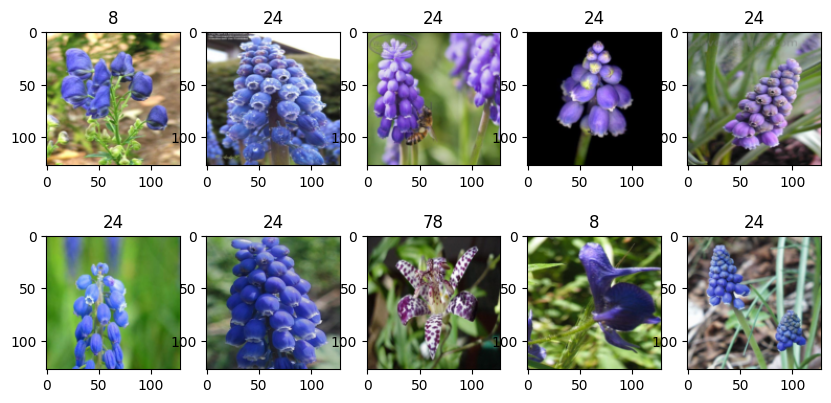

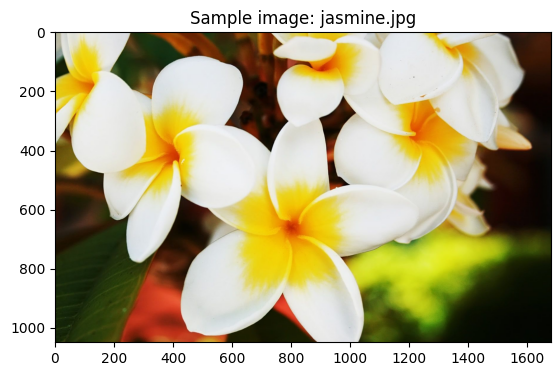

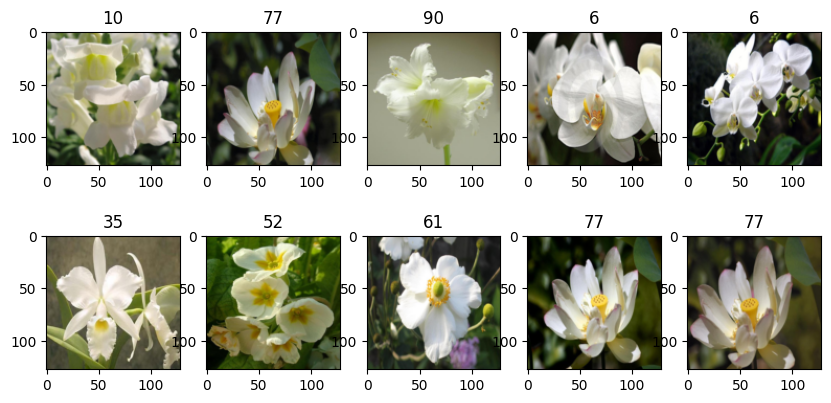

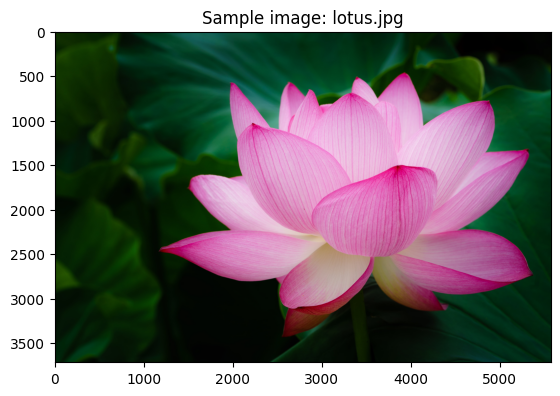

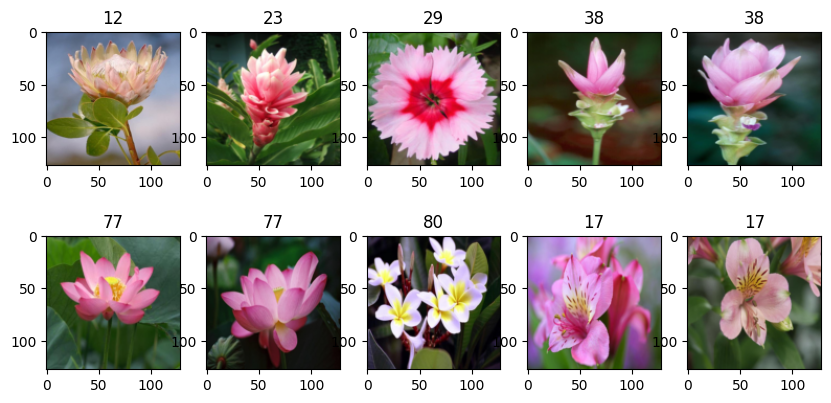

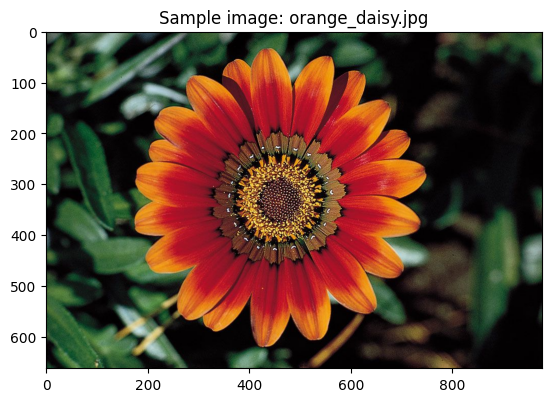

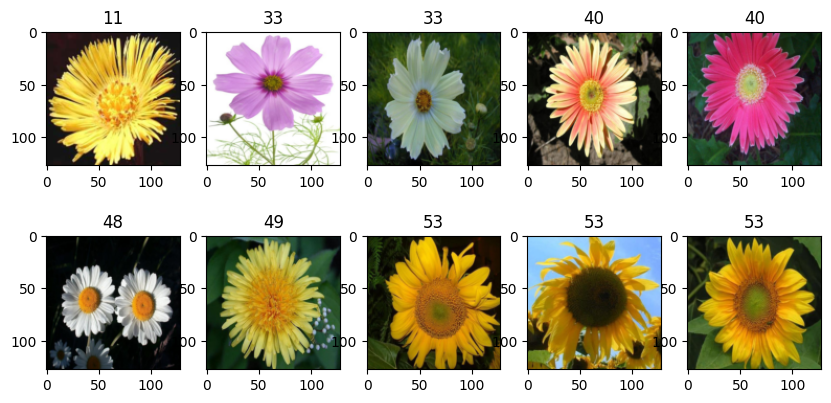

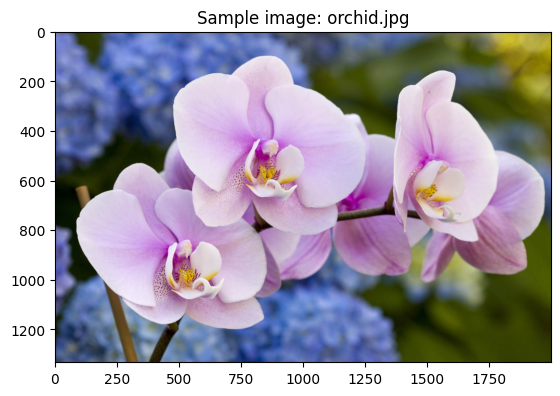

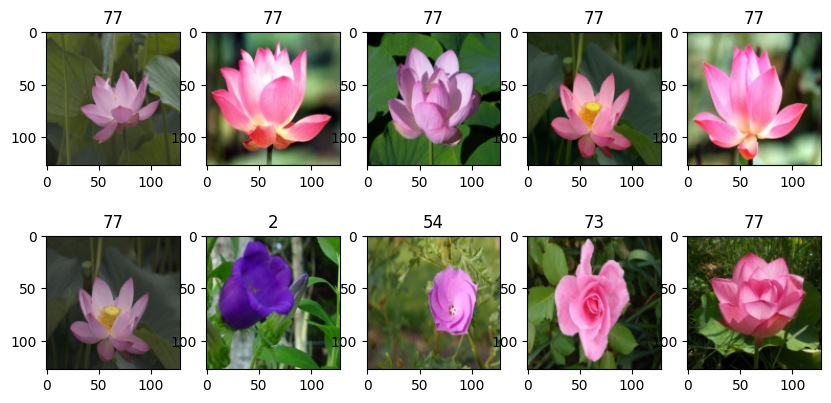

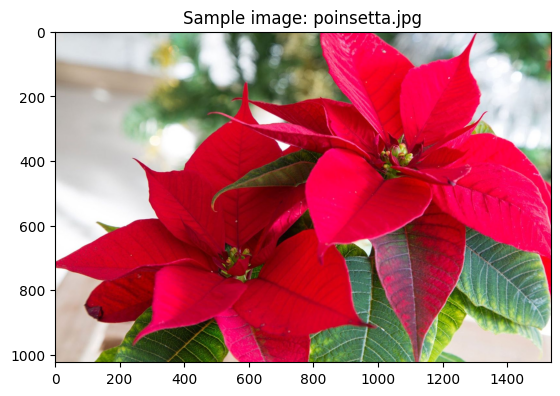

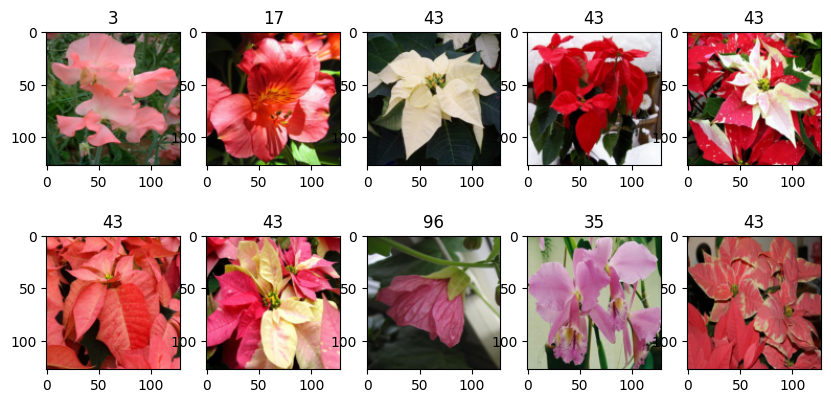

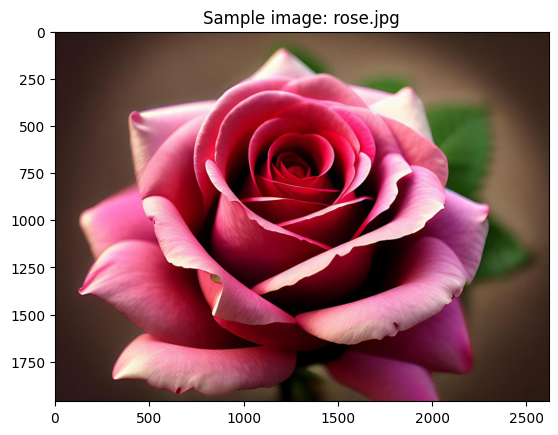

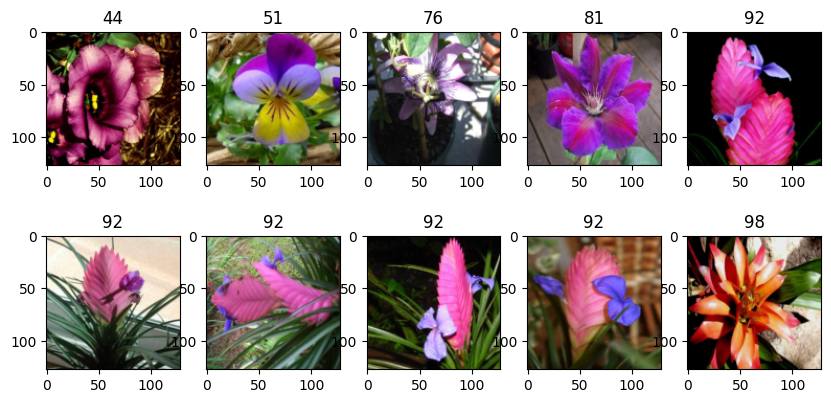

In [11]:
from pathlib import Path
IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

dir = Path('../test/')
image_files = [p for p in dir.rglob('*') if p.suffix.lower() in IMAGE_EXTS]

for image_path in image_files:
    print(image_path.name)
    results = search_tfis.search_similar(image_path)
    plot_image_from_path(image_path)
    plot_images_from_index(search_tfis.data_loader, results)    